In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install finance-datareader

In [ ]:
import os
import pandas as pd
import re
import FinanceDataReader as fdr
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

**데이터 전처리**

In [ ]:
df_merged = pd.read_csv('/content/drive/MyDrive/23-2 창의적종합설계 /LSTM/231205/eco_merged.csv')

In [ ]:
df_merged.head()

,Date,Open,High,Low,Close,Volume,Change,news_prob,news_prob_scaled,jongto_prob,jongto_prob_scaled
0,2023-02-01,123500,129500,123500,128400,569539,0.045603,0.492574,0.720895,0.543173,0.588008
1,2023-02-02,130500,132000,129400,131000,451433,0.020249,0.492537,0.719629,0.543541,0.592710
2,2023-02-03,130800,142200,129100,137600,1194656,0.050382,0.493239,0.744021,0.542775,0.582911
3,2023-02-06,138500,149000,138200,146200,1350414,0.062500,0.492233,0.709026,0.546016,0.624390
4,2023-02-07,147200,178100,147000,165900,3892423,0.134747,0.492440,0.716227,0.540820,0.557894


In [ ]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

scaled = scaler.fit_transform(df_merged[scale_cols])
scaled

array([[0.        , 0.        , 0.        , 0.        , 0.06541586],
       [0.00593472, 0.00177368, 0.00582716, 0.00223253, 0.03496483],
       [0.00618906, 0.00901029, 0.00553086, 0.00789971, 0.22658851],
       [0.01271725, 0.01383469, 0.01451852, 0.01528422, 0.26674728],
       [0.02009326, 0.03448031, 0.02320988, 0.0321999 , 0.92214833],
       [0.03620178, 0.03306137, 0.04019753, 0.03812468, 0.5511893 ],
       [0.04171259, 0.04767648, 0.04740741, 0.05383823, 0.91028721],
       [0.05900805, 0.04930827, 0.06044444, 0.05117637, 0.31764175],
       [0.05383637, 0.04945016, 0.06074074, 0.05873261, 0.24693887],
       [0.06375583, 0.049663  , 0.06350617, 0.05907608, 0.25278976],
       [0.06655362, 0.06491664, 0.07604938, 0.0730723 , 0.42412548],
       [0.08223824, 0.07981554, 0.08790123, 0.09496823, 0.47026148],
       [0.08647732, 0.07733239, 0.09037037, 0.07908295, 0.61851282],
       [0.08096651, 0.07733239, 0.09432099, 0.09239224, 0.42727923],
       [0.09919457, 0.08620078, 0.

In [ ]:
tmp = pd.DataFrame()

In [ ]:
tmp['news_prob'] = df_merged['news_prob']
tmp['news_prob_scaled'] = df_merged['news_prob_scaled']
tmp['jongto_prob'] = df_merged['jongto_prob']
tmp['jongto_prob_scaled'] = df_merged['jongto_prob_scaled']

In [ ]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   news_prob           114 non-null    float64
 1   news_prob_scaled    114 non-null    float64
 2   jongto_prob         114 non-null    float64
 3   jongto_prob_scaled  114 non-null    float64
dtypes: float64(4)
memory usage: 3.7 KB


In [ ]:
tmp = tmp.reset_index(drop=True)

In [ ]:
df_tmp = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
df_tmp['news_prob'] = tmp['news_prob']
df_tmp['news_prob_scaled'] = tmp['news_prob_scaled']
df_tmp['jongto_prob'] = tmp['jongto_prob']
df_tmp['jongto_prob_scaled'] = tmp['jongto_prob_scaled']

In [ ]:
df_tmp.head()

,Open,High,Low,Close,Volume,news_prob,news_prob_scaled,jongto_prob,jongto_prob_scaled
0,0.000000,0.000000,0.000000,0.000000,0.065416,0.492574,0.720895,0.543173,0.588008
1,0.005935,0.001774,0.005827,0.002233,0.034965,0.492537,0.719629,0.543541,0.592710
2,0.006189,0.009010,0.005531,0.007900,0.226589,0.493239,0.744021,0.542775,0.582911
3,0.012717,0.013835,0.014519,0.015284,0.266747,0.492233,0.709026,0.546016,0.624390
4,0.020093,0.034480,0.023210,0.032200,0.922148,0.492440,0.716227,0.540820,0.557894


In [ ]:
df = pd.DataFrame()

In [ ]:
df['Open'] = df_tmp['Open']
df['High'] = df_tmp['High']
df['Low'] = df_tmp['Low']
df['Close'] = df_tmp['Close']
df['Volume'] = df_tmp['Volume']
# df['news_prob'] = df_tmp['news_prob']
# df['news_prob'] = df_tmp['news_prob_scaled']
# df['jongto_prob'] = df_tmp['jongto_prob']
# df['jongto_prob'] = df_tmp['jongto_prob_scaled']

In [ ]:
df

,Open,High,Low,Close,Volume
0,0.000000,0.000000,0.000000,0.000000,0.065416
1,0.005935,0.001774,0.005827,0.002233,0.034965
2,0.006189,0.009010,0.005531,0.007900,0.226589
3,0.012717,0.013835,0.014519,0.015284,0.266747
4,0.020093,0.034480,0.023210,0.032200,0.922148
...,...,...,...,...,...
109,0.868588,0.845335,0.984198,1.000000,0.453423
110,1.000000,1.000000,1.000000,0.944187,0.696348
111,0.912675,0.759489,0.827160,0.735532,0.652705
112,0.705808,0.696346,0.801481,0.837713,0.449219


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

<ipython-input-20-01714d5140c3>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [ ]:
x_train.shape, y_train.shape

((91, 4), (91,))

In [ ]:
x_test.shape, y_test.shape

((23, 4), (23,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.000000,0.000000,0.000000,0.065416
1,0.005935,0.001774,0.005827,0.034965
2,0.006189,0.009010,0.005531,0.226589
3,0.012717,0.013835,0.014519,0.266747
4,0.020093,0.034480,0.023210,0.922148
...,...,...,...,...
86,0.529462,0.458673,0.609877,0.091221
87,0.548114,0.455835,0.626667,0.003185
88,0.538788,0.459383,0.626667,0.013652
89,0.536244,0.447322,0.581235,0.128169


**시퀀스 데이터셋 구성**

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=3
BATCH_SIZE=1

In [ ]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (1, 3, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (1, 1)


**모델**

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[None,7]),
    # LSTM,
    LSTM(32, activation='relu',return_sequences=True),
    LSTM(16, activation='relu',return_sequences=False),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [ ]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=100,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     82/Unknown - 11s 6ms/step - loss: 0.0251 - mse: 0.0503
Epoch 1: val_loss improved from inf to 0.05264, saving model to tmp/ckeckpointer.ckpt
88/88 [==============================] - 12s 19ms/step - loss: 0.0238 - mse: 0.0476 - val_loss: 0.0526 - val_mse: 0.1053
Epoch 2/100
82/88 [==========================>...] - ETA: 0s - loss: 0.0054 - mse: 0.0108
Epoch 2: val_loss improved from 0.05264 to 0.03863, saving model to tmp/ckeckpointer.ckpt
88/88 [==============================] - 1s 9ms/step - loss: 0.0053 - mse: 0.0106 - val_loss: 0.0386 - val_mse: 0.0773
Epoch 3/100
82/88 [==========================>...] - ETA: 0s - loss: 0.0034 - mse: 0.0069
Epoch 3: val_loss improved from 0.03863 to 0.01885, saving model to tmp/ckeckpointer.ckpt
88/88 [==============================] - 1s 8ms/step - loss: 0.0034 - mse: 0.0068 - val_loss: 0.0188 - val_mse: 0.0377
Epoch 4/100
84/88 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0041
Epoch 4: val_loss improved from 0

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

20/20 [==============================] - 1s 3ms/step


In [ ]:
pred.shape

(20, 1)

In [ ]:
pred

array([[0.58119595],
       [0.6398979 ],
       [0.70095205],
       [0.7094218 ],
       [0.73665833],
       [0.7448737 ],
       [0.7568583 ],
       [0.7451854 ],
       [0.73881686],
       [0.73381776],
       [0.75842965],
       [0.79296464],
       [0.8309418 ],
       [0.868349  ],
       [0.8680524 ],
       [0.8755927 ],
       [0.9229423 ],
       [0.95499575],
       [0.9449033 ],
       [0.8735071 ]], dtype=float32)

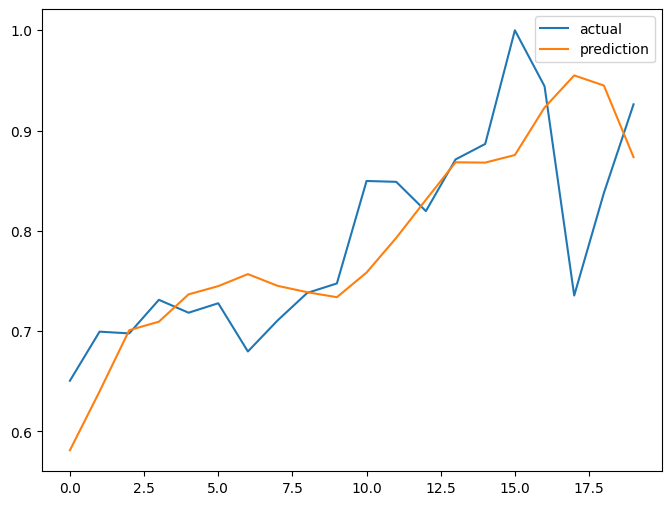

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.asarray(y_test)[3:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
